### This script reads all disparity images, transforms them to metric depth and saves it as a numpy array in a .txt file

In [ ]:


#import packages
import json
import os
import cv2
import glob
import numpy as np
from tqdm import tqdm

# baseline and focal point are needed to transform the png disparity to metric depth
def get_cam_params(jsonfile):
    '''This function reads the json file containing the camera parameters and reads the Fx and baseline'''
    
    with open(jsonfile, 'r') as f:
        file_data = json.load(f)

    #extrinsic and intrinsic parameters
    extrinsic = file_data['extrinsic']
    intrinsic = file_data['intrinsic']
   
    #baseline and focal point
    baseline = extrinsic['baseline']
    fx = intrinsic['fx']
    
    return baseline,fx


def transform_to_depth(image_path, fx, baseline):
    "this function reads a depth image and transforms is to a array of metric depth"
    
    #load image
    disp_image = cv2.imread(i, cv2.IMREAD_UNCHANGED).astype(np.float32)

    #transform disparity to metric depth
    disp_image[disp_image > 0] = (disp_image[disp_image > 0] - 1) / 256
    disp_image[disp_image > 0] = fx*baseline/(disp_image[disp_image > 0])
    disp_image[disp_image == 0] = 475

    #round values
    depth_image = np.round(disp_image,2)
    
    return depth_image

In [104]:
#path to disparity images
DISP_PATH = r"C:\Users\portierl4527\ARCADIS\Afstuderen Levi - Depth estimation - General\Cityscapes-Sequence\disparity_sequence_trainvaltest\disparity_sequence"
#path to camera parameters
CAM_PATH = r"C:\Users\portierl4527\ARCADIS\Afstuderen Levi - Depth estimation - General\Cityscapes-Dataset\00_Source_Data\camera"
cam_parameters = glob.glob(CAM_PATH+'/*.json')


cities = []

#Disp path contains val, train, test folder
for folder in os.listdir(DISP_PATH):
    folders = glob.glob(os.path.join(DISP_PATH,folder))
    
    #each folder contains a folder with city name
    for subfolder in os.listdir(os.path.join(DISP_PATH, folder)):
        subfolders = glob.glob(os.path.join(DISP_PATH,folder,subfolder))
        
        #add directory of city folders containing the images to the list
        cities.append(subfolders)

#flatten list
cities_flat = list(np.concatenate(cities).flat)
cities_to_iterate=cities_flat

#optional: select one city to iterate over
cities_to_iterate = [city for city in cities_flat if city.endswith('bonn')]

In [105]:
#for every folder in the list of city directories
for i in cities_to_iterate:
 
    for cam_file in cam_parameters:
        
        # read the camera parameters of the corresponding city
        if os.path.basename(cam_file).startswith(os.path.basename(i)):
            baseline,fx = get_cam_params(cam_file)
            
    #disparity images in the folder of current city
    disparity = glob.glob(os.path.join(i)+'/*.png')
    
    #for each image
    for i in tqdm(disparity):
    
        depth_image = transform_to_depth(i, fx, baseline) #transform image

        #name for out-file
        basename = os.path.basename(i)
        basename_no_ext = os.path.splitext(basename)[0]
        
        #define savepath
        savepath = "C:/Users/portierl4527/ARCADIS/Afstuderen Levi - Depth estimation - General/Cityscapes-Sequence/disparity_sequence_trainvaltest/gt_depth"
        
        #save as numpy file
        np.save(savepath  + '/' + basename_no_ext + '.npy', depth_image)

100%|██████████████████████████████████████████████████████████████████████████████| 1380/1380 [03:16<00:00,  7.04it/s]


#### Show an image to see the result

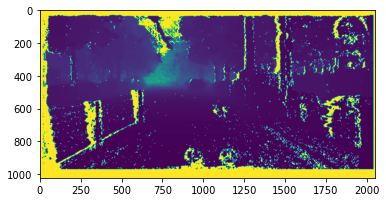

In [108]:
import matplotlib.pyplot as plt
dat = r"C:/Users/portierl4527/ARCADIS/Afstuderen Levi - Depth estimation - General/Cityscapes-Sequence/disparity_sequence_trainvaltest/gt_depth"
dat = glob.glob(dat+'\*.npy')
data =np.load(dat[0])
plt.imshow(data)